In [1]:
import sys
sys.path.append("C:\\Users\\lucas\\AppData\\Local\\Programs\\Python\\Python36\\Lib\\site-packages")

import os
import gc
import re
import sys
import math
import pickle
import warnings
import unidecode
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from IPython.display import display
from collections import defaultdict
from bayes_opt import BayesianOptimization
from scipy.optimize import minimize_scalar
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix as cfm, precision_recall_fscore_support as score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: f'{x:.6f}')

#### Model the failure probability of devices
- Failure -> costs 1
- Maintenance -> costs 0,5

In [2]:
df = pd.read_csv('full_devices.csv', encoding='latin-1')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [4]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


#### Check and drop Duplicates

In [5]:
df.drop_duplicates(inplace=True)
df.shape

(124493, 12)

In [6]:
df[df.duplicated(['date','device'])].shape

(0, 12)

#### Check nulls

In [7]:
df.isnull().sum()[df.isnull().sum()>0].shape

(0,)

#### Check Target

In [8]:
display(df['failure'].value_counts(normalize=True))
display(df['failure'].value_counts())

0   0.999149
1   0.000851
Name: failure, dtype: float64

0    124387
1       106
Name: failure, dtype: int64

#### Given the costs of maintenance and failure, and the failure proportion, at the moment i'm thinking it should have a focus on ensuring precision, to avoid unnecessary recurrent maintenance (false positive)

##### Attributes 7 and 8 seem to be the same, also attributes 3 and 9 have a considerable correlation

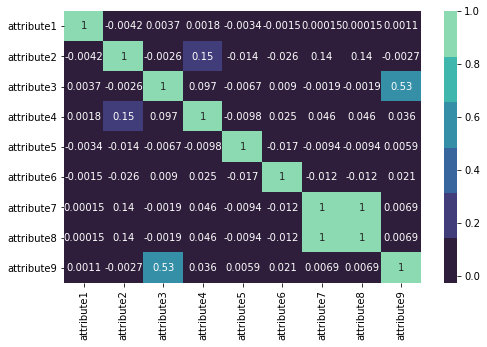

In [9]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(df.drop(['date','device','failure'],axis=1).corr(), annot=True,ax=ax,cmap=sns.color_palette("mako"))

Getting a confirmation to drop attribute 7 or 8

In [10]:
print(df['attribute7'].equals(df['attribute8']))

True


In [11]:
df.drop(['attribute8'],axis=1,inplace=True)

**Hypothesis**
- Device characters
- Previous failure by device

In [12]:
df['date'] = pd.to_datetime(df['date'])
failures_by_date = df.groupby('date')['failure'].sum().reset_index()

### Failures Over Time
<a id="failures-over-time"></a>

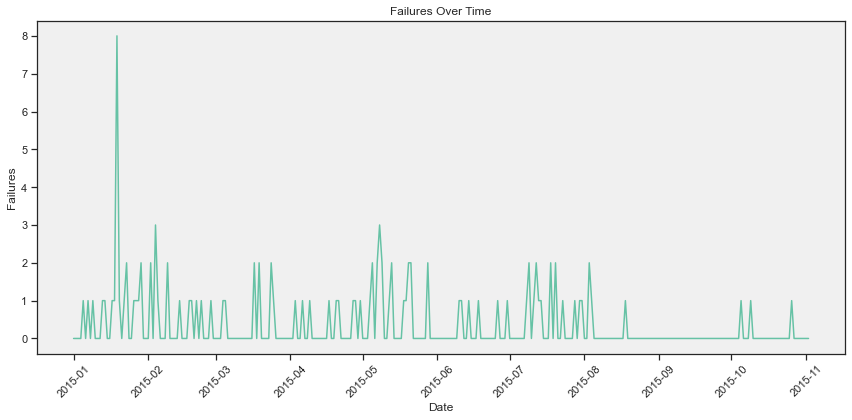

In [13]:
sns.set(style='ticks', palette='Set2')
plt.figure(figsize=(12, 6))
sns.lineplot(data=failures_by_date, x='date', y='failure')
plt.xlabel('Date')
plt.ylabel('Failures')
plt.title('Failures Over Time')
plt.xticks(rotation=45)
plt.gca().set_facecolor('#f0f0f0')
plt.tight_layout()
plt.show()

In [14]:
df['year_month'] = df['date'].apply(lambda x: str(x)[:7])
df['year_month'].value_counts()

2015-01    25032
2015-03    19833
2015-02    19500
2015-04    12012
2015-05    11330
2015-07    10530
2015-06    10469
2015-08     8346
2015-09     4470
2015-10     2940
2015-11       31
Name: year_month, dtype: int64

#### I can see a kind of pattern looking at the characters of device name, i'm splitting it 2 by 2 to see if it discriminates failures

In [15]:
print(df['device'].nunique())
df['device'].value_counts()[:10]

1169


S1F0H6JG    304
Z1F0QK05    304
S1F0E9EP    304
Z1F0GE1M    304
Z1F0KKN4    304
Z1F0QLC1    304
W1F0JH87    304
Z1F0GB8A    304
W1F05X69    304
W1F0SJJ2    304
Name: device, dtype: int64

In [16]:
df[['dev0', 'dev1', 'dev2', 'dev3']] = df['device'].str.extractall(r'(.{2})')[0].unstack()

In [17]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,year_month,dev0,dev1,dev2,dev3
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,2015-01,S1,F0,10,85
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,2015-01,S1,F0,16,6B
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,2015-01,S1,F0,1E,6Y
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,2015-01,S1,F0,1J,E0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3,2015-01,S1,F0,1R,2B


###### 11 months of Data

In [18]:
print(df.date.min())
print(df.date.max())

2015-01-01 00:00:00
2015-11-02 00:00:00


In [19]:
df.sort_values('date',ascending=True,inplace=True)

#### 106 failures, no devices failed twice

In [20]:
df_gb_failure = df.groupby('device').agg({'failure':'sum'}).reset_index().sort_values('failure',ascending=False)
df_gb_failure = df_gb_failure[df_gb_failure['failure']==1]
print(df_gb_failure.shape[0])
df_gb_failure.head()

106


,device,failure
1025,Z1F0LSNZ,1
820,W1F1230J,1
1066,Z1F0P5D9,1
118,S1F0L0DW,1
933,W1F1DQN8,1


##### Looks like after failure, devices are "retired", also, attribute 6 seems to grow over time

In [21]:
df_failure = df[df['device'].isin(df_gb_failure['device'])].sort_values(['device','date'],ascending=True)
df_failure[df_failure.duplicated('device')][:20]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,year_month,dev0,dev1,dev2,dev3
1170,2015-01-02,S1F023H2,0,161679800,0,0,1,19,495730,16,3,2015-01,S1,F0,23,H2
2333,2015-01-03,S1F023H2,0,182358672,0,0,1,19,496974,16,3,2015-01,S1,F0,23,H2
3496,2015-01-04,S1F023H2,0,204752808,0,0,1,19,497559,16,3,2015-01,S1,F0,23,H2
4658,2015-01-05,S1F023H2,0,226982888,0,0,1,19,498753,16,3,2015-01,S1,F0,23,H2
5819,2015-01-06,S1F023H2,0,10387472,0,0,1,19,499964,16,3,2015-01,S1,F0,23,H2
6868,2015-01-07,S1F023H2,0,30083248,0,0,1,19,501239,16,3,2015-01,S1,F0,23,H2
7666,2015-01-08,S1F023H2,0,55079280,0,0,1,19,502542,16,3,2015-01,S1,F0,23,H2
8422,2015-01-09,S1F023H2,0,78898848,0,0,1,19,503812,16,3,2015-01,S1,F0,23,H2
9178,2015-01-10,S1F023H2,0,107573856,0,0,1,19,505079,16,3,2015-01,S1,F0,23,H2
9933,2015-01-11,S1F023H2,0,134464552,0,0,1,19,505504,16,3,2015-01,S1,F0,23,H2


##### 5 devices have not been retired after fail

In [22]:
display(df_failure.drop_duplicates('device',keep='last')[['device','date','failure']]['failure'].value_counts())
not_retired = df_failure.drop_duplicates('device',keep='last')[df['failure']==0]['device'].tolist()
not_retired

1    101
0      5
Name: failure, dtype: int64

['S1F0GPFZ', 'S1F136J0', 'W1F0KCP2', 'W1F0M35B', 'W1F11ZG9']

In [23]:
df_failure.drop_duplicates('device',keep='last')[df['failure']==0]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,year_month,dev0,dev1,dev2,dev3
106061,2015-07-24,S1F0GPFZ,0,149669752,0,0,0,9,279540,0,0,2015-07,S1,F0,GP,FZ
78335,2015-05-06,S1F136J0,0,194511456,0,0,28,16,343593,0,0,2015-05,S1,F1,36,J0
80399,2015-05-11,W1F0KCP2,0,140419256,10440,0,121,6,310801,0,0,2015-05,W1,F0,KC,P2
80410,2015-05-11,W1F0M35B,0,181444320,456,0,1,7,267488,8,0,2015-05,W1,F0,M3,5B
113922,2015-08-17,W1F11ZG9,0,133230384,648,9,533,3,344660,0,1,2015-08,W1,F1,1Z,G9


##### The devices were retired "soon" after failure (except for device W1F11ZG9, ~1month)

In [24]:
not_retired_fail_dates = df_failure[df_failure['device'].isin(not_retired) & df_failure['failure']==1]['date'].tolist()

##### They need to be flagged as different from other devices

In [25]:
df['previous_fail'] = 0
for i,j in zip(not_retired,not_retired_fail_dates):
    print(i,j)
    df.loc[(df['device']==i) & (df['date']>j),'previous_fail'] = 1

S1F0GPFZ 2015-07-12 00:00:00
S1F136J0 2015-05-05 00:00:00
W1F0KCP2 2015-05-09 00:00:00
W1F0M35B 2015-05-09 00:00:00
W1F11ZG9 2015-07-18 00:00:00


#### Hypothesis: Devices chances of failure increase with use time

In [26]:
df.sort_values(['device','date'],ascending=True,inplace=True)
df['use_time'] = df.groupby('device').cumcount() + 1

#### It still doesn't seem possible to assert anything about it just by looking at the statistics

In [27]:
print('failure 0')
display(df[df['failure']==0]['use_time'].describe())
print('failure 1')
display(df[df['failure']==1]['use_time'].describe())

failure 0


count   124387.000000
mean       103.180590
std         77.213300
min          1.000000
25%         38.000000
50%         83.000000
75%        162.000000
max        304.000000
Name: use_time, dtype: float64

failure 1


count   106.000000
mean    100.622642
std      75.416362
min       5.000000
25%      26.500000
50%      92.000000
75%     148.000000
max     299.000000
Name: use_time, dtype: float64

#### Quick feature selection (want to discard as many dummies as possible)

##### Creating dummies for dev columns

In [28]:
dev_columns = ['dev0', 'dev1', 'dev2', 'dev3']
dev_df = df[dev_columns]
dummy_df = pd.get_dummies(dev_df)
df = pd.concat([df, dummy_df], axis=1)
df = df.drop(dev_columns, axis=1)

In [29]:
#Random Forest
modelo = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1, verbose=1)
modelo.fit(df.drop(['date','year_month','device','failure'],axis=1),df['failure'])
importances = pd.Series(modelo.feature_importances_,index=df.drop(['date','year_month','device','failure'],axis=1).columns)
importances.sort_values(ascending=False,inplace=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.9s finished


#### I'm taking all features above 0.0015 importance

In [30]:
print(len(importances[importances>0.0012]))
importances[importances>0.0012]

31


use_time        0.283994
attribute6      0.185436
attribute1      0.162077
attribute4      0.073373
attribute2      0.062031
attribute7      0.045797
attribute5      0.026278
attribute9      0.009506
dev0_W1         0.003892
dev0_S1         0.003589
dev2_T0         0.002444
previous_fail   0.002401
attribute3      0.002198
dev2_35         0.002180
dev3_ZP         0.002144
dev0_Z1         0.002062
dev3_B0         0.001980
dev1_F1         0.001910
dev2_CJ         0.001703
dev2_M4         0.001636
dev3_TN         0.001631
dev1_F0         0.001569
dev3_T1         0.001537
dev2_3D         0.001509
dev3_TV         0.001469
dev3_4L         0.001465
dev3_5N         0.001425
dev2_LD         0.001358
dev2_RR         0.001354
dev2_GG         0.001254
dev2_S6         0.001214
dtype: float64

In [31]:
features_baseline = ['attribute1','attribute2','attribute3','attribute4','attribute5','attribute6','attribute7','attribute9']
features_ = importances[importances>0.0012].index.tolist()

In [32]:
#Mixing it up again
df = df.sample(frac = 1)
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,year_month,previous_fail,use_time,dev0_S1,dev0_W1,dev0_Z1,dev1_F0,dev1_F1,dev1_F2,dev2_00,dev2_01,dev2_02,dev2_07,dev2_0A,dev2_0B,dev2_0C,dev2_0D,dev2_0E,dev2_0F,dev2_0G,dev2_0H,dev2_0J,dev2_0N,dev2_0P,dev2_0Q,dev2_0R,dev2_0V,dev2_0Y,dev2_10,dev2_11,dev2_13,dev2_14,dev2_15,dev2_16,dev2_17,dev2_18,dev2_19,dev2_1A,dev2_1B,dev2_1C,dev2_1D,dev2_1E,dev2_1F,dev2_1G,dev2_1J,dev2_1K,dev2_1L,dev2_1M,dev2_1R,dev2_1S,dev2_1T,dev2_1W,dev2_1X,dev2_1Y,dev2_1Z,dev2_21,dev2_22,dev2_23,dev2_27,dev2_2A,dev2_2D,dev2_2E,dev2_2J,dev2_2K,dev2_2L,dev2_2M,dev2_2N,dev2_2P,dev2_2V,dev2_2W,dev2_2X,dev2_2Y,dev2_2Z,dev2_30,dev2_31,dev2_32,dev2_33,dev2_34,dev2_35,dev2_36,dev2_37,dev2_39,dev2_3B,dev2_3C,dev2_3D,dev2_3E,dev2_3G,dev2_3H,dev2_3J,dev2_3K,dev2_3M,dev2_3R,dev2_3S,dev2_3Y,dev2_44,dev2_47,dev2_48,dev2_49,dev2_4B,dev2_4C,dev2_4D,dev2_4F,dev2_4G,dev2_4H,dev2_4K,dev2_4M,dev2_4N,dev2_4R,dev2_4T,dev2_4X,dev2_4Y,dev2_4Z,dev2_51,dev2_56,dev2_59,dev2_5A,dev2_5B,dev2_5H,dev2_5N,dev2_5P,dev2_5S,dev2_5V,dev2_5X,dev2_61,dev2_63,dev2_65,dev2_6B,dev2_6E,dev2_6F,dev2_6G,dev2_6L,dev2_6Q,dev2_6R,dev2_6W,dev2_6Y,dev2_6Z,dev2_7D,dev2_7E,dev2_7G,dev2_7R,dev2_7X,dev2_7Y,dev2_7Z,dev2_81,dev2_82,dev2_8B,dev2_8E,dev2_8J,dev2_8K,dev2_8P,dev2_8R,dev2_8S,dev2_8T,dev2_8Y,dev2_90,dev2_95,dev2_97,dev2_9B,dev2_9D,dev2_9E,dev2_9H,dev2_9J,dev2_9K,dev2_9L,dev2_9M,dev2_9Q,dev2_9T,dev2_9V,dev2_9W,dev2_A0,dev2_A1,dev2_A2,dev2_A4,dev2_A7,dev2_A8,dev2_AA,dev2_AD,dev2_AE,dev2_AF,dev2_AG,dev2_AH,dev2_AM,dev2_AN,dev2_AQ,dev2_AR,dev2_B0,dev2_B3,dev2_B4,dev2_B5,dev2_B6,dev2_B7,dev2_BA,dev2_BF,dev2_BG,dev2_BJ,dev2_BN,dev2_BQ,dev2_BR,dev2_BS,dev2_BT,dev2_BV,dev2_BW,dev2_BZ,dev2_C0,dev2_C5,dev2_C9,dev2_CA,dev2_CB,dev2_CC,dev2_CD,dev2_CE,dev2_CH,dev2_CJ,dev2_CK,dev2_CL,dev2_CM,dev2_CN,dev2_CR,dev2_CS,dev2_CT,dev2_CV,dev2_CW,dev2_CZ,dev2_D8,dev2_D9,dev2_DA,dev2_DK,dev2_DN,dev2_DP,dev2_DQ,dev2_DS,dev2_DX,dev2_DZ,dev2_E1,dev2_E2,dev2_E7,dev2_E9,dev2_ED,dev2_EE,dev2_EG,dev2_EW,dev2_F4,dev2_F6,dev2_FA,dev2_FC,dev2_FE,dev2_FG,dev2_FH,dev2_FK,dev2_FM,dev2_FP,dev2_FS,dev2_FV,dev2_FW,dev2_FY,dev2_FZ,dev2_G0,dev2_G5,dev2_G9,dev2_GB,dev2_GC,dev2_GE,dev2_GG,dev2_GH,dev2_GJ,dev2_GK,dev2_GL,dev2_GM,dev2_GP,dev2_GQ,dev2_GR,dev2_GS,dev2_GV,dev2_H6,dev2_H9,dev2_HE,dev2_HJ,dev2_HN,dev2_HP,dev2_HR,dev2_HS,dev2_HT,dev2_HW,dev2_HY,dev2_J5,dev2_J7,dev2_J9,dev2_JA,dev2_JD,dev2_JE,dev2_JG,dev2_JH,dev2_JM,dev2_JX,dev2_JY,dev2_K4,dev2_K9,dev2_KA,dev2_KC,dev2_KD,dev2_KG,dev2_KH,dev2_KJ,dev2_KK,dev2_KQ,dev2_KR,dev2_KS,dev2_KY,dev2_KZ,dev2_L0,dev2_L1,dev2_L2,dev2_L3,dev2_L4,dev2_L5,dev2_L6,dev2_L7,dev2_LB,dev2_LC,dev2_LD,dev2_LE,dev2_LH,dev2_LJ,dev2_LK,dev2_LL,dev2_LM,dev2_LN,dev2_LQ,dev2_LR,dev2_LS,dev2_LT,dev2_LV,dev2_LY,dev2_LZ,dev2_M0,dev2_M2,dev2_M3,dev2_M4,dev2_M6,dev2_M7,dev2_MA,dev2_MB,dev2_MC,dev2_MM,dev2_MN,dev2_MP,dev2_MQ,dev2_MR,dev2_MS,dev2_MT,dev2_MW,dev2_MX,dev2_MY,dev2_MZ,dev2_N0,dev2_N1,dev2_N2,dev2_N4,dev2_N5,dev2_N6,dev2_N7,dev2_N8,dev2_NB,dev2_NF,dev2_NN,dev2_NS,dev2_NT,dev2_NV,dev2_NZ,dev2_P1,dev2_P2,dev2_P3,dev2_P4,dev2_P5,dev2_P6,dev2_PA,dev2_PB,dev2_PE,dev2_PF,dev2_PG,dev2_PJ,dev2_PK,dev2_PL,dev2_PN,dev2_PS,dev2_PX,dev2_Q5,dev2_Q8,dev2_Q9,dev2_QE,dev2_QF,dev2_QG,dev2_QH,dev2_QK,dev2_QL,dev2_QQ,dev2_QS,dev2_QT,dev2_QW,dev2_QX,dev2_QY,dev2_QZ,dev2_R0,dev2_R1,dev2_R2,dev2_R3,dev2_R4,dev2_R7,dev2_R8,dev2_R9,dev2_RE,dev2_RG,dev2_RJ,dev2_RK,dev2_RL,dev2_RM,dev2_RN,dev2_RQ,dev2_RR,dev2_RS,dev2_RT,dev2_RV,dev2_RX,dev2_S0,dev2_S1,dev2_S2,dev2_S3,dev2_S4,dev2_S5,dev2_S6,dev2_S7,dev2_S9,dev2_SA,dev2_SB,dev2_SC,dev2_SF,dev2_SG,dev2_SJ,dev2_SN,dev2_SR,dev2_SV,dev2_SW,dev2_T0,dev2_T1,dev2_T2,dev2_T3,dev2_T4,dev2_T9,dev2_TA,dev2_TB,dev2_TC,dev2_TD,dev2_TG,dev2_TH,dev2_TJ,dev2_TK,dev2_TM,dev2_TN,dev2_TP,dev2_TQ,dev2_TX,dev2_TY,dev2_V8,dev2_VA,dev2_VC,dev2_VD,dev2_VE,dev2_VF,dev2_VJ,dev2_VK,dev2_VL,dev2_VM,dev2_VN,dev2_VQ,dev2_VV,dev2_VZ,dev2_W0,dev2_W1,dev2_W2,dev2_W3,dev2_W4,dev2_W5,dev2_W6,dev2_W8,dev2_W9,d

In [33]:
X_ = df[features_] # Includes created features
X = df[features_baseline] # Original data features
y = df['failure']

In [34]:
X.reset_index(inplace=True,drop=True)
X_.reset_index(inplace=True,drop=True)
y.reset_index(inplace=True,drop=True)

### Establishing a Baseline

In [35]:
def compare_baselines(X,y): 

    # I'm testing 3 different classification algorithms, RF (Bagging) and XGBoost/LGBM (Boosting)
    xgb_clf = xgb.XGBClassifier(random_state=42)
    rf_clf = RandomForestClassifier(random_state=42)
    lgbm_clf = lgb.LGBMClassifier(random_state=42)

    n_folds = 5
    fold_results = []
    
    # StratifiedKFold to keep the right class proportions
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        fold_data = {}

        # XGBoost 
        xgb_clf.fit(X_train, y_train)
        y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
        fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba_xgb)
        auc_xgb = auc(fpr_xgb, tpr_xgb)

        fold_data['xgb'] = {
            'fpr': fpr_xgb,
            'tpr': tpr_xgb,
            'thresholds': thresholds_xgb,
            'auc': auc_xgb
        }

        # Random Forest 
        rf_clf.fit(X_train, y_train)
        y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
        fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
        auc_rf = auc(fpr_rf, tpr_rf)

        fold_data['rf'] = {
            'fpr': fpr_rf,
            'tpr': tpr_rf,
            'thresholds': thresholds_rf,
            'auc': auc_rf
        }

        # LGBM
        lgbm_clf.fit(X_train, y_train)
        y_proba_lgbm = lgbm_clf.predict_proba(X_test)[:, 1]
        fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, y_proba_lgbm)
        auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

        fold_data['lgbm'] = {
            'fpr': fpr_lgbm,
            'tpr': tpr_lgbm,
            'thresholds': thresholds_lgbm,
            'auc': auc_lgbm
        }

        fold_results.append(fold_data)

    # Find the iteration with the best AUC for each classifier
    best_auc_idx_xgb = np.argmax([fold['xgb']['auc'] for fold in fold_results])
    best_auc_idx_rf = np.argmax([fold['rf']['auc'] for fold in fold_results])
    best_auc_idx_lgbm = np.argmax([fold['lgbm']['auc'] for fold in fold_results])

    mean_auc_xgb = np.mean([fold['xgb']['auc'] for fold in fold_results])
    mean_auc_rf = np.mean([fold['rf']['auc'] for fold in fold_results])
    mean_auc_lgbm = np.mean([fold['lgbm']['auc'] for fold in fold_results])
    plt.figure(figsize=(10, 8))

    # XGBoost ROC
    best_fold_data_xgb = fold_results[best_auc_idx_xgb]['xgb']
    plt.plot(best_fold_data_xgb['fpr'], best_fold_data_xgb['tpr'], label='XGBoost (AUC = {:.3f})'.format(best_fold_data_xgb['auc']))
    best_optimal_threshold_xgb = best_fold_data_xgb['thresholds'][np.argmax(best_fold_data_xgb['tpr'] - best_fold_data_xgb['fpr'])]
    plt.plot(best_fold_data_xgb['fpr'][np.argmax(best_fold_data_xgb['tpr'] - best_fold_data_xgb['fpr'])],
             best_fold_data_xgb['tpr'][np.argmax(best_fold_data_xgb['tpr'] - best_fold_data_xgb['fpr'])], 'ro')

    # RF ROC 
    best_fold_data_rf = fold_results[best_auc_idx_rf]['rf']
    plt.plot(best_fold_data_rf['fpr'], best_fold_data_rf['tpr'], label='Random Forest (AUC = {:.3f})'.format(best_fold_data_rf['auc']))
    best_optimal_threshold_rf = best_fold_data_rf['thresholds'][np.argmax(best_fold_data_rf['tpr'] - best_fold_data_rf['fpr'])]
    plt.plot(best_fold_data_rf['fpr'][np.argmax(best_fold_data_rf['tpr'] - best_fold_data_rf['fpr'])],
             best_fold_data_rf['tpr'][np.argmax(best_fold_data_rf['tpr'] - best_fold_data_rf['fpr'])], 'ro')

    # LGBM ROC
    best_fold_data_lgbm = fold_results[best_auc_idx_lgbm]['lgbm']
    plt.plot(best_fold_data_lgbm['fpr'], best_fold_data_lgbm['tpr'], label='LGBM (AUC = {:.3f})'.format(best_fold_data_lgbm['auc']))
    best_optimal_threshold_lgbm = best_fold_data_lgbm['thresholds'][np.argmax(best_fold_data_lgbm['tpr'] - best_fold_data_lgbm['fpr'])]
    plt.plot(best_fold_data_lgbm['fpr'][np.argmax(best_fold_data_lgbm['tpr'] - best_fold_data_lgbm['fpr'])],
             best_fold_data_lgbm['tpr'][np.argmax(best_fold_data_lgbm['tpr'] - best_fold_data_lgbm['fpr'])], 'ro')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Print the optimal thresholds
    print("Optimal Threshold for XGBoost: {:.4f}".format(best_optimal_threshold_xgb))
    print("Optimal Threshold for Random Forest: {:.4f}".format(best_optimal_threshold_rf))
    print("Optimal Threshold for LGBM: {:.4f}".format(best_optimal_threshold_lgbm))

    # Print the AUC means
    print("Mean AUC for XGBoost: {:.4f}".format(mean_auc_xgb))
    print("Mean AUC for Random Forest: {:.4f}".format(mean_auc_rf))
    print("Mean AUC for LGBM: {:.4f}".format(mean_auc_lgbm))

#### Baselines (Original vs New Features)
<a id="baseline"></a>

[16:03:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

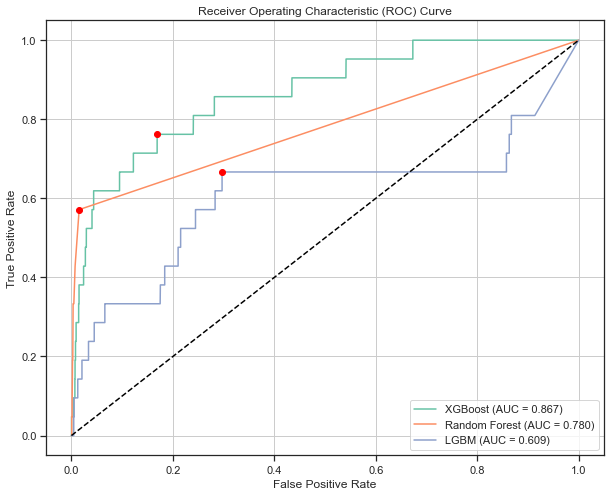

Optimal Threshold for XGBoost: 0.0002
Optimal Threshold for Random Forest: 0.0100
Optimal Threshold for LGBM: 0.0000
Mean AUC for XGBoost: 0.8496
Mean AUC for Random Forest: 0.7251
Mean AUC for LGBM: 0.4707


In [59]:
compare_baselines(X,y)

[16:06:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

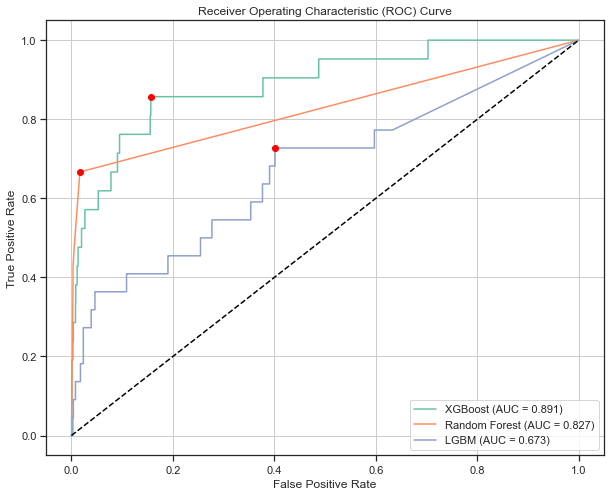

Optimal Threshold for XGBoost: 0.0002
Optimal Threshold for Random Forest: 0.0100
Optimal Threshold for LGBM: 0.0000
Mean AUC for XGBoost: 0.8567
Mean AUC for Random Forest: 0.7625
Mean AUC for LGBM: 0.5885


In [62]:
compare_baselines(X_,y)

### For now we are discarding just the LGBM, XGBoost have better AUC but "costs" more False Positives than Random Forest, which is bad

In [69]:
optimal_threshold = best_optimal_threshold_xgb
scale_pos_weight = 124387 / 106 #failure rate to define weight to classes, as it is a very unbalanced problem

def xgboost_objective(learning_rate, num_leaves, min_data_in_leaf, max_depth, colsample_bytree):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': precision_score,
        'verbosity': 0,
        'learning_rate': learning_rate,
        'num_leaves': int(num_leaves),
        'min_data_in_leaf': int(min_data_in_leaf),
        'max_depth': int(max_depth),
        'colsample_bytree': colsample_bytree,
        'scale_pos_weight': scale_pos_weight,
        'n_jobs': -1
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    precisions = []
    recalls = []
    f1s = []
    
    for train_index, val_index in skf.split(X_, y):
        X_train, X_val = X_.loc[train_index], X_.loc[val_index]
        y_train, y_val = y.loc[train_index], y.loc[val_index]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_val)[:, 1]
        y_pred = (y_proba >= optimal_threshold).astype(int)
        
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
    
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        
    return np.mean(precision)

# Defining the parameter bounds for Bayesian Optimization
pbounds = {
    'learning_rate': (0.001, 0.1),
    'num_leaves': (10, 100),
    'min_data_in_leaf': (10, 100),
    'max_depth': (3, 10),
    'colsample_bytree': (0.2, 0.8),
}

optimizer = BayesianOptimization(f=xgboost_objective, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

|   iter    |  target   | colsam... | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------
| 1         | 0.0008437 | 0.4247    | 0.09512   | 8.124     | 63.88     | 24.04     |
| 2         | 0.0008434 | 0.2936    | 0.00675   | 9.063     | 64.1      | 73.73     |
| 3         | 0.0008435 | 0.2124    | 0.09702   | 8.827     | 29.11     | 26.36     |
| 4         | 0.0008434 | 0.31      | 0.03112   | 6.673     | 48.88     | 36.21     |
| 5         | 0.0008434 | 0.5671    | 0.01481   | 5.045     | 42.97     | 51.05     |
| 6         | 0.0008434 | 0.6711    | 0.02077   | 6.6       | 63.32     | 14.18     |
| 7         | 0.0008434 | 0.5645    | 0.01788   | 3.455     | 95.4      | 96.91     |
| 8         | 0.0008434 | 0.685     | 0.03116   | 3.684     | 71.58     | 49.61     |
| 9         | 0.0008434 | 0.2732    | 0.05002   | 3.241     | 91.84     | 33.29     |
| 10        | 0.0008434 | 0.5975    | 0.03186   | 6.64

In [67]:
best_params_xgb = optimizer.max['params']
best_params_xgb['max_depth'] = int(best_params_xgb['max_depth'])
best_params_xgb['scale_pos_weight'] = scale_pos_weight
best_params_xgb['random_state']= 42
best_params_xgb['n_jobs']= -1

In [78]:
optimal_threshold = best_optimal_threshold_rf

def rf_objective(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'max_features': max_features,
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    precisions = []
    recalls = []
    f1s = []
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_val)[:, 1]
        y_pred = (y_proba >= optimal_threshold).astype(int)
        
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
    
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    print("recall mean: ", np.mean(recalls))        
    return np.mean(precision)

# Defining the parameter bounds for Bayesian Optimization
pbounds = {
    'n_estimators': (80, 600),
    'max_depth': (3, 10),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10),
    'max_features': (0.2, 0.8)
}

optimizer_rf = BayesianOptimization(f=rf_objective, pbounds=pbounds, random_state=42)
optimizer_rf.maximize(init_points=10, n_iter=10)
print(optimizer_rf.max)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
recall mean:  0.4346320346320347
| 1         | 0.03463   | 5.622     | 0.7704    | 7.588     | 12.78     | 161.1     |
recall mean:  0.2727272727272727
| 2         | 0.03846   | 4.092     | 0.2349    | 8.796     | 12.82     | 448.2     |
recall mean:  0.36796536796536794
| 3         | 0.05344   | 3.144     | 0.7819    | 8.492     | 5.822     | 174.5     |
recall mean:  0.41558441558441556
| 4         | 0.04188   | 4.284     | 0.3825    | 5.723     | 9.775     | 231.4     |
recall mean:  0.47186147186147187
| 5         | 0.03125   | 7.283     | 0.2837    | 3.629     | 8.595     | 317.2     |
recall mean:  0.4528138528138528
| 6         | 0.02682   | 8.496     | 0.3198    | 5.628     | 12.66     | 104.2     |
recall mean:  0.4623376623376624
| 7         | 0.03226   | 7.253     | 0.3023    | 1.585     | 19.08     | 582.

#### The optimized version of Random Forest is outperforming XGBoost on the metric i want to perform better, i'm following the bagging way

In [ ]:
best_params_rf = optimizer_rf.max['params']

In [108]:
best_params_rf['max_depth'] = int(best_params_rf['max_depth'])
best_params_rf['n_estimators'] = int(best_params_rf['n_estimators'])
best_params_rf['min_samples_leaf'] = int(best_params_rf['min_samples_leaf'])
best_params_rf['min_samples_split'] = int(best_params_rf['min_samples_split'])
best_params_rf['random_state']= 42
best_params_rf['n_jobs']= -1

In [109]:
best_params_rf

{'max_depth': 3,
 'max_features': 0.7819459112971967,
 'min_samples_leaf': 8,
 'min_samples_split': 5,
 'n_estimators': 174,
 'random_state': 42,
 'n_jobs': -1}

### Using the already tuned hyperparams, i'm averaging the best threshold according to f1-score, by "grid-searching" it  

### I'm also trying to visualize a custom cost metric, as it is well defined in the problem. But it should probably be used by the team who manage the budget for the maintenances, i guess it would be helpful to estimate the costs and maybe choose a optimal point based on what they have to spent each day/week/month

In [140]:
cost_false_positive = 0.5
cost_false_negative = 1

In [120]:
def find_best_threshold(X, y, model, threshold_range):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_threshold = None
    best_score = -np.inf
    l_precision = []
    l_recall = []
    l_threshold = []
    with tqdm(total=len(threshold_range)) as pbar:
        for threshold in threshold_range:
            l_threshold.append(threshold)
            scores = []
            precisions = []
            recalls = []
            f1s = []
            costs_metric = []
            
            for train_index, val_index in skf.split(X, y):
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]

                model.fit(X_train, y_train)
                y_proba = model.predict_proba(X_val)[:, 1]
                y_pred = (y_proba >= threshold).astype(int)

                precision = precision_score(y_val, y_pred)
                recall = recall_score(y_val, y_pred)
                f1 = f1_score(y_val,y_pred)
                
                tn, fp, fn, tp = cfm(y_val, y_pred).ravel()
                custom_cost_metric = (fp*cost_false_positive) + (fn*cost_false_negative)

                costs_metric.append(custom_cost_metric)
                precisions.append(precision)
                recalls.append(recall)
                f1s.append(f1)

            mean_f1 = np.mean(f1s)
            mean_precision = np.mean(precisions)
            mean_recall = np.mean(recalls)
            
            l_precision.append(mean_precision)
            l_recall.append(mean_recall)
            
            print(f"Threshold: {threshold} / Mean Score: {mean_f1} / Mean Precision: {np.mean(precisions)} / Mean Recall: {np.mean(recall)} / Mean Cost: {np.mean(costs_metric)}")
            if mean_f1 > best_score:
                best_score = mean_f1
                best_threshold = threshold
                
            pbar.update(1)

    return best_threshold, best_score, l_precision, l_recall, l_threshold

model = RandomForestClassifier(**best_params_rf)
threshold_range = np.linspace(0.001, 0.02, 20) 

best_threshold, best_score, l_precision, l_recall, l_threshold = find_best_threshold(X, y, model, threshold_range)
print("Best threshold:", best_threshold)

Threshold: 0.001 / Mean Score: 0.020706563388001968 / Mean Precision: 0.010511236502559734 / Mean Recall: 0.7142857142857143 / Mean Cost: 705.1
Threshold: 0.002 / Mean Score: 0.027163967642116982 / Mean Precision: 0.013893067599253411 / Mean Recall: 0.6190476190476191 / Mean Cost: 485.7
Threshold: 0.003 / Mean Score: 0.0299223489283831 / Mean Precision: 0.015330713012856578 / Mean Recall: 0.6190476190476191 / Mean Cost: 432.4
Threshold: 0.004 / Mean Score: 0.03269498752243755 / Mean Precision: 0.016811640476071348 / Mean Recall: 0.5714285714285714 / Mean Cost: 381.7
Threshold: 0.005 / Mean Score: 0.03691210586813445 / Mean Precision: 0.019143849117659754 / Mean Recall: 0.5714285714285714 / Mean Cost: 315.3
Threshold: 0.006 / Mean Score: 0.04502722463638591 / Mean Precision: 0.023597745717726413 / Mean Recall: 0.5714285714285714 / Mean Cost: 256.1
Threshold: 0.007 / Mean Score: 0.050036673295028686 / Mean Precision: 0.026550199890658967 / Mean Recall: 0.47619047619047616 / Mean Cost: 20

#### I guess the best threshold is actually one where we don't sacrifice too much recall, but have decent precision as well

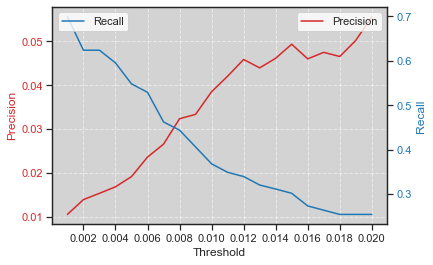

In [217]:
sns.set(style="ticks")
fig, ax1 = plt.subplots()
color1 = 'tab:red'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Precision', color=color1)
ax1.plot(l_threshold, l_precision, color=color1, label='Precision')
ax1.tick_params(axis='y', labelcolor=color1)
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Recall', color=color2)
ax2.plot(l_threshold, l_recall, color=color2, label='Recall')
ax2.tick_params(axis='y', labelcolor=color2)
ax1.set_facecolor('lightgray')
ax1.grid(True, linestyle='--', alpha=0.5, color='white')
plt.xticks(rotation=45)
plt.locator_params(axis='x', nbins=len(l_threshold))
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()

### It's easier to understand and explain to businesses by using this kind of plot, i'm taking the point closest to the intersection between the precision and recall lines 
- 0.008

In [40]:
data = {
    'Threshold': l_threshold,
    'Precision': l_precision,
    'Recall': l_recall
}
df = pd.DataFrame(data)
display(df[df['Threshold']==0.008])
best_threshold = 0.008

### Now we have everything we need, i'm generating a confusion matrix to make it more tangible

In [160]:
def run_test(params,thresh):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    precisions = []
    recalls = []
    tp_values = []
    tn_values = []
    fp_values = []
    fn_values = []
    
    for train_index, test_index in skf.split(X_, y):
        X_train, X_test = X_.loc[train_index], X_.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        if params == None:
            model = RandomForestClassifier(random_state=42)
        else:
            model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= thresh).astype(int)
        
        tn, fp, fn, tp = cfm(y_test, y_pred).ravel()
        
        tp_values.append(tp)
        tn_values.append(tn)
        fp_values.append(fp)
        fn_values.append(fn)
        
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        precisions.append(precision.round(4))
        recalls.append(recall.round(4))

    print('Precision mean:', np.mean(precisions))
    print('Recall mean:', np.mean(recalls))

    mean_tp = int(np.mean(tp_values))
    mean_tn = int(np.mean(tn_values))
    mean_fp = int(np.mean(fp_values))
    mean_fn = int(np.mean(fn_values))

    confusion_matrix = np.array([[mean_tp, mean_fp], [mean_fn, mean_tn]])
    sns.heatmap(confusion_matrix, fmt='d', annot=True, cmap='Blues', cbar=False, square=True)
    labels = ['Positive', 'Negative']
    plt.xlabel('Predicted label')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(len(labels)) + 0.5, labels)
    plt.yticks(np.arange(len(labels)) + 0.5, labels)
    plt.show()
    
    return confusion_matrix

#### I'm taking a non conventional approach by plotting the mean confusion matrix values besides the conventional metrics, just to have a meticulous look at the results

Precisions: [0.0235, 0.0409, 0.0319, 0.0359, 0.0395]
Precision mean: 0.034339999999999996
Recalls: [0.5238, 0.4286, 0.3636, 0.381, 0.4762]
Recall mean: 0.43464


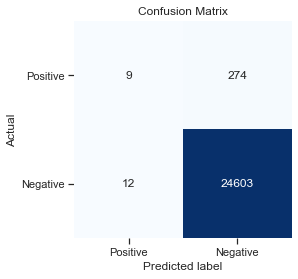

In [161]:
cf_matrix = run_test(best_params_rf,best_threshold)

### As this is all the data we have, i want to simulate the "future prediction", so i'm taking the last months as test to see how it goes
#### (decided for 2015-08 and beyond by looking at [this plot](#failures-over-time))

In [37]:
# Splitting train/test data
X_train = df[df['year_month']<'2015-08'][features_]
X_test = df[df['year_month']>='2015-08'][features_]
y_train = df[df['year_month']<'2015-08']['failure']
y_test = df[df['year_month']>='2015-08']['failure']

In [38]:
# Statistics about failure on train/test
print(f"Train Failure count: ", y_train.sum())
print(f"Train Failure rate: ", y_train.mean())
print(f"Test Failure count: ", y_test.sum())
print(f"Test Failure rate: ", y_test.mean())

Train Failure count:  99
Train Failure rate:  0.000910713300093831
Test Failure count:  7
Test Failure rate:  0.0004434027997719643


In [41]:
model = RandomForestClassifier(**best_params_rf)
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= best_threshold).astype(int)

In [42]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision:', precision)
print('Recall:', recall)

Precision: 0.004246284501061571
Recall: 0.2857142857142857


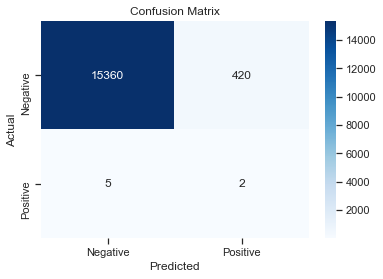

In [208]:
cm = cfm(y_test, y_pred)
labels = ['Negative', 'Positive']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### I'd not include the last months in the training with the information i have, as it would add a lot more non-failures than failures

Persist model

In [43]:
with open('rf_failure_model.pkl', 'wb') as f:
    pickle.dump(model, f)

## I would have enjoyed testing an approach where we define a "near failure" target a couple days before the complete failure, so we could maximize the days before maintenance is really necessary, and the model would have a lot more target to learn

### Also the Random Forest perform some balancing but i'd test a couple undersampling techniques on the non-failure class or even oversampling the failures with an algorithm such as SMOTE